In [1]:
import numpy as np
from scipy.integrate import solve_ivp, solve_bvp
from scipy.spatial.transform import Rotation as rot
import matplotlib.pyplot as plt

import plotly.graph_objects as go

**Cosserat rod equations according to various sources:**

[Rucker & Webster 2011 (STATICS)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5957337) | [Gazzola et al 2018 (DYNAMICS)](https://mattia-lab.com/wp-content/uploads/2018/06/Gazzola_RSOS_2018.pdf)
- | -
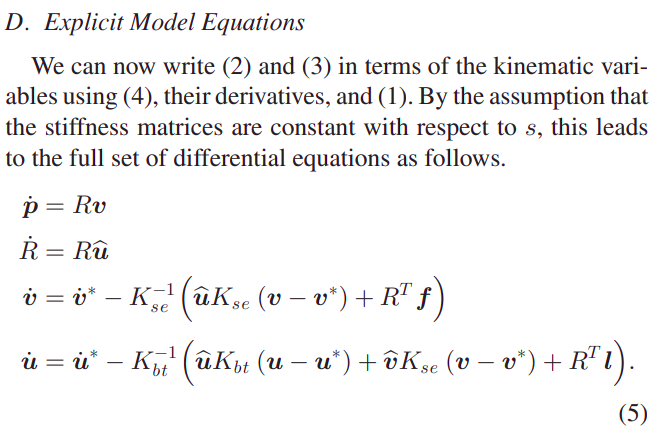 | 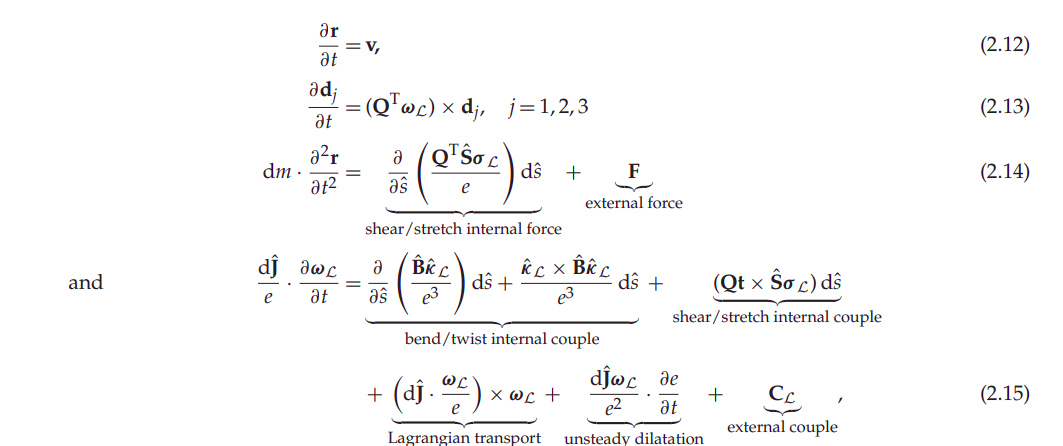


## Implementing Rucker & Webster
There are two conceptual ways of working with these equations. 
1. The first way is to roll everything into one ode solve: where $p, R, v, u$ is your state vectors. This is equivalent to the usual way of separating out a 2nd order ODE into a system of first order ones via $v := \dot{x}$ and the state vector thus as $X = [x, v]$. It's just now you have rotational components as well.
2. Since $\dot{p}$ and $\dot{R}$ are fully determined by $v$ and $u$, we can separate this out into two steps of integration: integrate $\dot{v}, \dot{u}$ numerically to obtain $v,u$, but then analytically integrate those via $\exp()$ to find the corresponding $p, R$. In theory, integrating $v$ and $u$ analytically via $\exp()$ should be as accurate as using a solver. The caveat is that the resolution is defined in the separate integration step.

In [239]:
# 3D kinematics/geometry helper functions
def mat_skew_sym_3(omega):
    # Create 3x3 skew-symmetric matrix given a 3-vector
    # Aka create the corresponding matrix to a cross-product
    # For converting an angular velocity vector to its matrix form
    # 
    # TODO: take a list of omega vectors?
    
    x, y, z = omega
    
    Omega = np.array([
        [0, -x, y],
        [x, 0, -z],
        [-y, z, 0]
    ])
    
    return Omega

def mat_skew_sym_4(omega):
    # Skew symmetric matrix for converting body frame angular velocities to the dq/dt quaternion rate of change
    # See https://math.stackexchange.com/questions/1797542/can-quaternions-be-used-to-represent-rotation-rate
    x, y, z = omega
    
    # Omega = np.array([
    #     [0, -x, -y, -z],
    #     [x, 0, z, -y],
    #     [y, -z, 0, x],
    #     [z, y, -x, 0]
    # ])
    
    # Correction for SciPy quaternions having the real component at the end:
    Omega = np.array([
        [-x, -y, -z, 0],
        [0, z, -y, x],
        [-z, 0, x, y],
        [y, -x, 0, z]
    ])
    
    return Omega

# Implement Rucker's equation
# y:= [p, R, v, u]
# 
# We store R not as its full rotation matrix but instead in quaternion form, giving a final expanded state:
# [x, y, z, q1, q2, q3, q4, v1, v2, v3, u1, u2, u3]
def rate_func(s, y, f, l, v_star, u_star, vdot_star, udot_star, K_se, K_bt):    
    p = y[0:3]
    R_q = y[3:7]
    v = y[7:10]
    u = y[10:13]
    
    # Apply conversions between matrix-vecor forms
    # !!!!! REMEMBER: SCIPY QUATERNIONS HAVE W LAST !!!!!
    R = rot.from_quat(R_q).as_matrix() # We store the rotation as quaternion in state for compactness; now convert to mat
    u_hat = mat_skew_sym_3(u)
    v_hat = mat_skew_sym_3(v)
    
    ## System of ODEs from Rucker
    # Rate of change of position is the body-frame velocity rotated to world frame:
    pdot = R @ v
    
    # Rate of change of orinetation quaternion in wordl frame is the skew-symmetric form of angular vel
    # converted to an angular velocity in world frame by multiplying with current orientation quaternion
    R_qdot = 0.5 * mat_skew_sym_4(u) @ R_q
    
    # Calculate forces and moments at the current point along the rod:
    # force per unit of s: N/m = kg m /s^2 m = kg/s^2
    # g / (rho*A) = m/s^2 * (kg/m^3 * m^2) = m/s^2 * kg/m = kg/s^2 :)
    rho_g_cm3 = 1.1 # g/cm^3
    rho = rho_g_cm3 * 100**2 / 1000 # kg/m^3
    A = (0.0254/4)**2 * np.pi # m^2
    f_g_world = np.array([0, 0, -9.8 * (rho*A)])
    f += f_g_world
    
    # Beam bending equlibrium constituitive equations
    vdot = vdot_star - np.linalg.inv(K_se) @ (u_hat @ K_se @ (v - v_star) + R.T @ f)
    udot = udot_star - np.linalg.inv(K_bt) @ (u_hat @ K_bt @ (u - u_star) + K_se @ v_hat @ (v - v_star) + R.T @ l)
    
    # import pdb; pdb.set_trace()
    
    dy = np.concatenate([pdot, R_qdot, vdot, udot])
    
    return dy

## Tools for working with / visualizing rod kinematics:
# !!!!! REMEMBER: SCIPY QUATERNIONS HAVE W LAST !!!!!
p_0 = np.array([0, 0, 0])
R_q_0 = rot.from_euler("xyz", [0, 0, 0], degrees=True).as_quat() # X is up
v_0 = np.array([1, 0, 0])
u_0 = np.array([0, 0, 0])

y_0 = np.concatenate([p_0, R_q_0, v_0, u_0])

f = np.array([0., 0., 0.])
l = np.array([0., 0., 0.])
K_se = np.diag([0.1, 10., 10.]) # Stiffnesses: [stretch, x_shear, y_shear]
K_bt = 0.1 * np.diag([100., 1., 1.]) # Stiffnesses: [torsion, bending_y, bending_z]

# TODO: You shouldn't need to define both v_star and vdot_star
# Could numerically differentiate one to get the other..?
# Also TODO: This is not equipped to handle varying v_star or vdot_star
# Which is rare for these rods but still possible.
v_star = np.array([1, 0, 0])
u_star = np.array([0, 0, 0])
vdot_star = np.array([0, 0, 0])
udot_star = np.array([0, 0, 0])

s = [0, 1]
soln = solve_ivp(rate_func, s, y_0, args=(f, l, v_star, u_star, vdot_star, udot_star, K_se, K_bt), rtol=1e-5, atol=1e-5)

In [232]:
M,N = 3,4

a = np.random.rand(100,N)
b = np.random.rand(100,M,N)

np.einsum('ij,ikj->ik',a,b).shape

(100, 3)

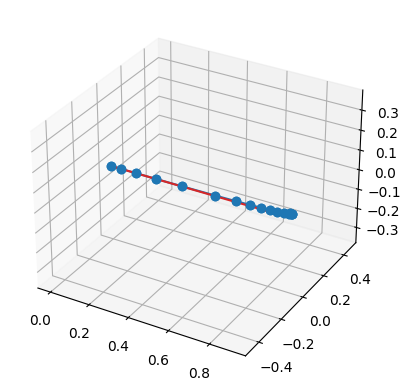

In [26]:
# Using matplotlib for now as plotly is being annoying about rods
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot(soln.y[0, :], soln.y[1, :], soln.y[2, :], marker='o')
ax.stem(soln.y[0, :], soln.y[1, :], soln.y[2, :])
# ax.axis("equal")
plt.show()

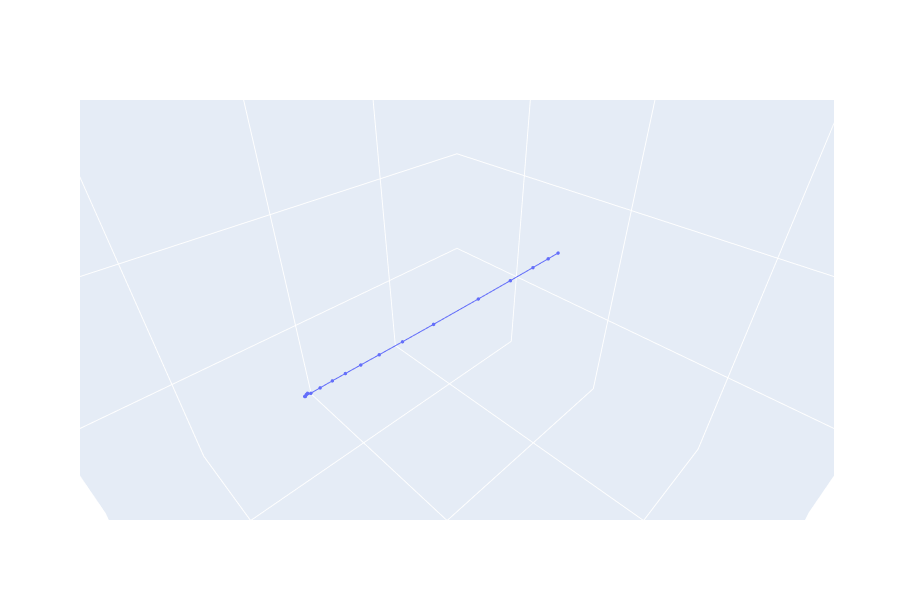

In [109]:
# TEMP: Round off small decimals so Plotly can plot equal ratios nicely :(
# TODO: Maybe find a nicer solution?
# soln.y = np.round(soln.y, 5)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x = soln.y[0, :],
    y = soln.y[1, :],
    z = soln.y[2, :],
    marker=dict(size=2)
))

mins = np.min(soln.y[0:3, :], axis=1)
maxs = np.max(soln.y[0:3, :], axis=1)
lims = np.array([mins, maxs]).T
ranges = maxs - mins
midpoints = np.atleast_2d(np.mean(lims, axis=1)).T
max_range = np.max(ranges)

new_ranges = midpoints + np.array([
    [-max_range, max_range],
    [-max_range, max_range],
    [-max_range, max_range]
])

fig.update_layout(
    scene=dict(
        aspectmode='manual',
        xaxis=dict(range=new_ranges[0, :]),
        yaxis=dict(range=new_ranges[1, :]),
        zaxis=dict(range=new_ranges[2, :])
    ),
    height=600,
    width=800,
)
fig.show()

In [266]:
def plot_transforms(posns, quats, axis_length=0.1, marker_size = 3, fig=go.Figure()):
    
    # 3D matrix which stores the list of individual points to plot for each body-axis (x, y, z)
    # For each pose: store start point (at the center of pose), end point of the body-axis, and then insert 'None' to separate lines.
    # Note there will be a trailing 'None'.
    numels = 3*len(posns.T)
    body_points_xyz = np.zeros((3, 3, numels))
    
    R = rot.from_quat(quats.T).as_matrix()
    
    idx = 0
    for i, posn in enumerate(posns.T):
        for i_axis, body_points_axis in enumerate(body_points_xyz):
            body_points_axis[:, idx] = posn
            body_points_axis[:, idx+1] = posn + R[i, :, i_axis] * axis_length
            body_points_axis[:, idx+2] = np.array([None, None, None])
        
        idx += 3
        
    axis_names = ["x", "y", "z"]
    axis_colors = ["red", "green", "blue"]
    for i, axis in enumerate(body_points_xyz):
        fig.add_trace(go.Scatter3d(
            x=axis[0, :],
            y=axis[1, :],
            z=axis[2, :],
            name=axis_names[i],
            mode="lines+markers",
            legendgroup="poses",
            showlegend=False,
            marker=dict(color=axis_colors[i], size=marker_size)
        ))
    
    fig.add_trace(go.Scatter3d(
        x=posns[0, :],
        y=posns[1, :],
        z=posns[2, :],
        mode="markers",
        name="Poses",
        legendgroup="poses",
        marker=dict(color="black", size=marker_size)
    ))
    
    return fig

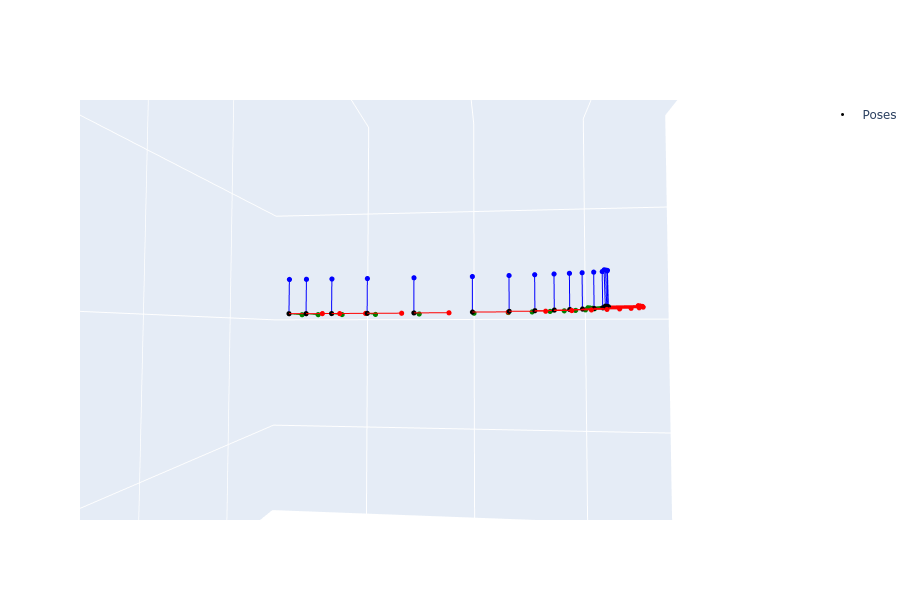

In [253]:
R = rot.from_quat(soln.y[3:7, :].T).as_matrix()

f_gravity_world = np.transpose(R, [0, 2, 1]) @ np.array([[0, 0, -9.8]]).T
f_gravity_world = np.squeeze(f_gravity_world).T

fig = go.Figure()
plot_transforms(soln.y[0:3, :], soln.y[3:7, :], fig=fig)

# fig.add_trace(go.Cone(
#     x=soln.y[0, :],
#     y=soln.y[1, :],
#     z=soln.y[2, :],
#     u=f_gravity_world[0, :],
#     v=f_gravity_world[1, :],
#     w=f_gravity_world[2, :],
#     sizemode="scaled",
#     sizeref=100,
#     colorbar=dict(len=0.5)
# ))

fig.update_layout(
    scene=dict(
        aspectmode='manual',
        xaxis=dict(range=new_ranges[0, :]),
        yaxis=dict(range=new_ranges[1, :]),
        zaxis=dict(range=new_ranges[2, :])
    ),
    height=600,
    width=800,
)

In [281]:
def rate_func_bvp(s, y):
    ## Define constants
    f = np.array([0., 0., 0.])
    l = np.array([0., 0., 0.])
    K_se = np.diag([0.1, 10., 10.]) # Stiffnesses: [stretch, x_shear, y_shear]
    K_bt = 0.1 * np.diag([100., 1., 1.]) # Stiffnesses: [torsion, bending_y, bending_z]

    # TODO: You shouldn't need to define both v_star and vdot_star
    # Could numerically differentiate one to get the other..?
    # Also TODO: This is not equipped to handle varying v_star or vdot_star
    # Which is rare for these rods but still possible.
    v_star = np.array([[1, 0, 0]]).T
    u_star = np.array([[0, 0, 0]]).T
    vdot_star = np.array([[0, 0, 0]]).T
    udot_star = np.array([[0, 0, 0]]).T
    
    p = y[0:3, :]
    R_q = y[3:7, :]
    n = y[7:10, :]
    m = y[10:13, :]
    
    # Apply conversions between matrix-vecor forms
    # !!!!! REMEMBER: SCIPY QUATERNIONS HAVE W LAST !!!!!
    R = rot.from_quat(R_q.T).as_matrix() # We store the rotation as quaternion in state for compactness; now convert to mat
    
    # u, v from m, n
    u = K_se @ np.einsum('ijk,ki->ji', np.transpose(R, [0, 2, 1]), m) + u_star
    v = K_se @ np.einsum('ijk,ki->ji', np.transpose(R, [0, 2, 1]), n) + v_star
    
    # u_hat = mat_skew_sym_3(u)
    # v_hat = mat_skew_sym_3(v)
    
    ## System of ODEs from Rucker
    # Rate of change of position is the body-frame velocity rotated to world frame:
    pdot = np.einsum('ijk,ki->ji', R, v)
    
    # Rate of change of orinetation quaternion in wordl frame is the skew-symmetric form of angular vel
    # converted to an angular velocity in world frame by multiplying with current orientation quaternion
    qdot = np.zeros(R_q.shape)
    for i, u_i in enumerate(u.T):
        R_qdot_i = 0.5 * mat_skew_sym_4(u_i) @ R_q[:, i]
        qdot[:, i] = R_qdot_i
           
    # Rate of change for m and n!
    ndot = np.zeros(n.shape)
    mdot = np.cross(-pdot, n, axis=0) - np.atleast_2d(l).T
    
    dy = np.vstack([pdot, qdot, ndot, mdot])    
    return dy

## Tools for working with / visualizing rod kinematics:
# !!!!! REMEMBER: SCIPY QUATERNIONS HAVE W LAST !!!!!
p_0 = np.array([0, 0, 0])
R_q_0 = rot.from_euler("xyz", [0, 0, 0], degrees=True).as_quat() # X is up
n_end = np.array([0, 0, -9.8*0.5])
m_end = np.array([0, 0, 0])

boundary_conditions = np.concatenate([p_0, R_q_0, n_end, m_end])
f_bound_conds = lambda ya, yb: np.concatenate([ya[0:7], yb[7:13]]) - boundary_conditions

s_grid = np.linspace(0, 1, 10)
y_0_mesh = np.repeat(np.atleast_2d(y_0).T, 10, axis=1)
y_0_mesh[0, :] = s_grid
                    
bvp_soln = solve_bvp(rate_func_bvp, f_bound_conds, s_grid, y_0_mesh)

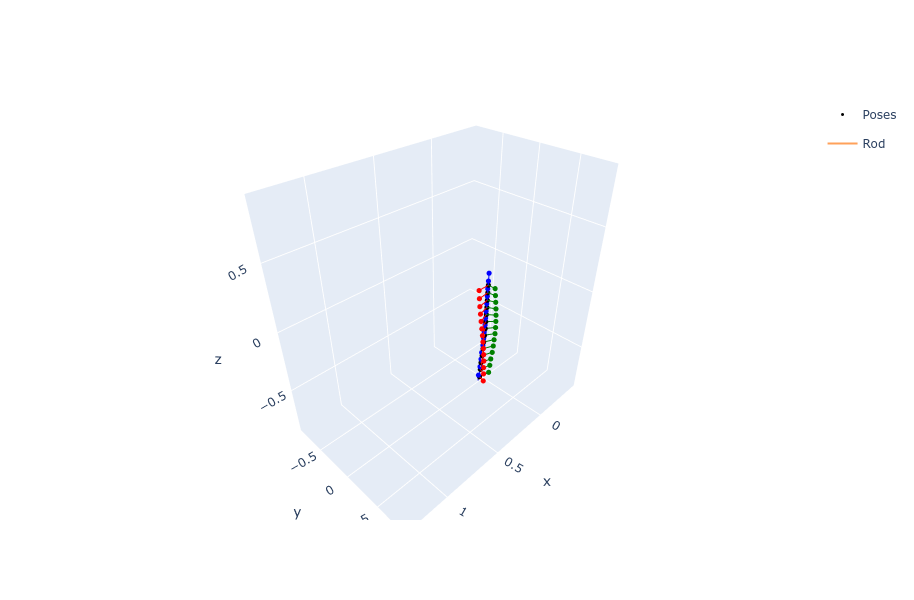

In [282]:
R = rot.from_quat(bvp_soln.y[3:7, :].T).as_matrix()

f_gravity_world = np.transpose(R, [0, 2, 1]) @ np.array([[0, 0, -9.8]]).T
f_gravity_world = np.squeeze(f_gravity_world).T

fig = go.Figure()
plot_transforms(bvp_soln.y[0:3, :], bvp_soln.y[3:7, :], fig=fig)

fig.add_trace(go.Scatter3d(
    x=bvp_soln.y[0, :],
    y=bvp_soln.y[1, :],
    z=bvp_soln.y[2, :],
    name="Rod",
    mode="lines"
))

fig.update_layout(
    scene=dict(
        aspectmode='manual',
        xaxis=dict(range=new_ranges[0, :]),
        yaxis=dict(range=new_ranges[1, :]),
        zaxis=dict(range=new_ranges[2, :])
    ),
    height=600,
    width=800,
)
